In [1]:
!pip3 install sgp4
!pip3 install skyfield
!pip3 install pyIGRF

  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Created wheel for pyIGRF: filename=pyIGRF-0.3.3-py3-none-any.whl size=14202 sha256=a646823a2de5bc6643e65fb10dcbda8afc2673cbaa58560508826a7021d47857
  Stored in directory: c:\users\merij\appdata\local\pip\cache\wheels\96\dd\a0\0ceb8dece7f6880c1dafbe912b8e3b8a9ce5f091a5709772bd
Successfully built pyIGRF


In [8]:
from sgp4.api import Satrec, WGS72
from skyfield.api import EarthSatellite, load, wgs84
import pyIGRF
import matplotlib.pyplot as plt
import numpy as np

In [16]:
class Spacecraft_Model():

    # Time step [s]
    dt = 0.01
    
    # Generate a satellite orbit using orbital elements
    # This orbit is for the ISS
    satrec = Satrec()
    satrec.sgp4init(
        WGS72,           # gravity model
        'i',             # 'a' = old AFSPC mode, 'i' = improved mode
        5,               # satnum: Satellite number
        18441.785,       # epoch: days since 1949 December 31 00:00 UT
        2.8098e-05,      # bstar: drag coefficient (/earth radii)
        6.969196665e-13, # ndot: ballistic coefficient (revs/day)
        0.0,             # nddot: second derivative of mean motion (revs/day^3)
        0.1859667,       # ecco: eccentricity
        5.7904160274885, # argpo: argument of perigee (radians)
        0.5980929187319, # inclo: inclination (radians)
        0.3373093125574, # mo: mean anomaly (radians)
        0.0472294454407, # no_kozai: mean motion (radians/minute)
        6.0863854713832, # nodeo: right ascension of ascending node (radians)
    )

    # Create a EarthSatellite object using the generated satellite orbit
    ts = load.timescale()
    sat = EarthSatellite.from_satrec(satrec,ts)

    def get_magnetic_field(self, date):
        sat = self.sat

        pos = sat.at(date)
        lat, lon = wgs84.latlon_of(pos)
        alt = wgs84.height_of(pos)
        return pyIGRF.igrf_value(lat.degrees, lon.degrees, alt.km, date.J)

    def graph_orbit(self):
        sat = self.sat
        
        hours = np.arange(0, 3, self.dt)
        time = self.ts.utc(2000, 6, 28, hours)
    
        sat_pos = sat.at(time).position.km
        sat_posecl = sat.at(time).ecliptic_position().km
    
        re = 6378.
        
        theta = np.linspace(0, 2*np.pi, 201)
        cth, sth, zth = (lambda theta=theta: [f(theta) for f in (np.cos, np.sin, np.zeros_like)])()
        lon0 = re*np.vstack((cth, zth, sth))
        lons = []
        for phi in (np.pi/180)*np.arange(0,180,15):
            cph, sph = (lambda phi=phi: [f(phi) for f in (np.cos, np.sin)])()
            lon = np.vstack((lon0[0]*cph - lon0[1]*sph,
                             lon0[1]*cph + lon0[0]*sph,
                             lon0[2]))
            lons.append(lon)
    
        lat0 = re*np.vstack((cth,sth,zth))
        lats = []
        for phi in (np.pi/180)*np.arange(-75, 90, 15):
            cph, sph = (lambda phi=phi: [f(phi) for f in (np.cos, np.sin)])()
            lat = re*np.vstack((cth*cph, sth*cph, zth+sph))
            lats.append(lat)
    
        fig = plt.figure(figsize=[10, 8])
        
        ax  = fig.add_subplot(1, 1, 1, projection='3d')
    
        x, y, z = sat_pos
        ax.plot(x, y, z)
        for x, y, z in lons:
            ax.plot(x, y, z, '-k')
        for x, y, z in lats:
            ax.plot(x, y, z, '-k')
    
        plt.show()
        

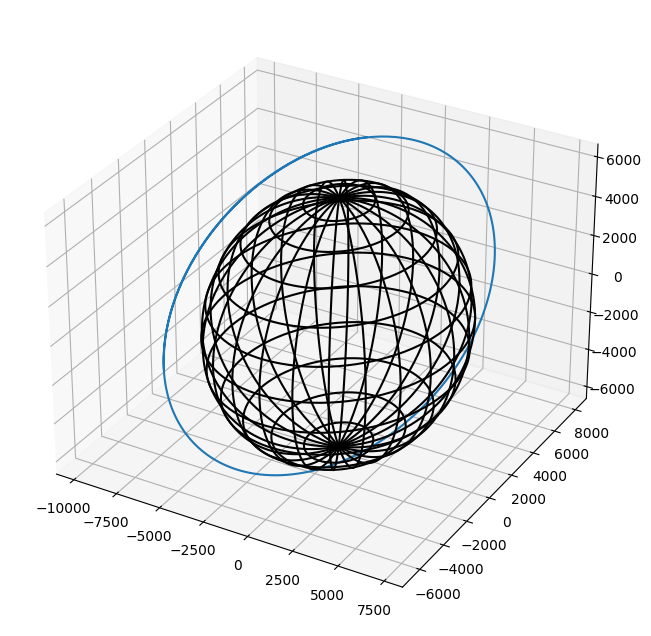

North component: 7281.43 nT
East component: 1344.19 nT
Vertical component: 7495.82 nT


In [19]:
spacecraft = Spacecraft_Model()
spacecraft.graph_orbit()
date = spacecraft.ts.utc(2000, 6, 28, 0)
d, i, h, x, y, z, f = spacecraft.get_magnetic_field(date)
print("North component: {:.2f} nT".format(x))
print("East component: {:.2f} nT".format(y))
print("Vertical component: {:.2f} nT".format(z))